# MIMIC-II IAC Survival Analysis

This tutorial explores the MIMIC-II IAC dataset. It was created for the purpose of a case study in the book: Secondary Analysis of Electronic Health Records, published by Springer in 2016. In particular, the dataset was used throughout Chapter 16 (Data Analysis) by Raffa J. et al. to investigate the effectiveness of indwelling arterial catheters in hemodynamically stable patients with respiratory failure for mortality outcomes. The dataset is derived from MIMIC-II, the publicly-accessible critical care database. It contains summary clinical data and  outcomes for 1,776 patients.

Reference: 

[1] Critical Data, M.I.T., 2016. Secondary analysis of electronic health records (p. 427). Springer Nature. (https://link.springer.com/book/10.1007/978-3-319-43742-2)

[2] https://github.com/MIT-LCP/critical-data-book/tree/master/part_ii/chapter_16/jupyter

[3] https://stackoverflow.com/questions/27328623/anova-test-for-glm-in-python/60769343#60769343

More details on the dataset can be found here: https://physionet.org/content/mimic2-iaccd/1.0/.

## Importing ehrapy and setting plotting parameters

In [146]:
import ehrapy as ep
import pandas as pd
import numpy as np
from statsmodels.stats.anova import anova_lm
from itertools import product
from lifelines import CoxPHFitter

In [147]:
import warnings

warnings.filterwarnings("ignore")

In [148]:
ep.print_versions()

-----
ehrapy              0.9.0
rich                NA
scanpy              1.10.4
session_info        1.0.0
-----
PIL                 11.0.0
anndata             0.11.1
appnope             0.1.4
asttokens           NA
attr                24.2.0
autograd            NA
autograd_gamma      NA
backports           NA
cachetools          5.5.0
causallearn         NA
certifi             2024.08.30
charset_normalizer  3.4.0
click               8.1.7
cloudpickle         3.1.0
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dask                2024.11.1
dask_expr           1.1.18
dask_ml             2024.4.4
dateutil            2.9.0.post0
db_dtypes           1.3.1
debugpy             1.8.8
decorator           5.1.1
defusedxml          0.7.1
dill                0.3.8
distributed         2024.11.1
dowhy               0.11.1
executing           2.1.0
fhiry               4.0.0
filelock            3.16.1
formulaic           1.0.2
fsspec              2024.6.1
google        

## MIMIC-II dataset preparation

In [149]:
adata = ep.dt.mimic_2(encoded=False)

It is also possible to get the MIMIC-II dataset already pre-encoded by setting the encoded flag to 'True'. ehrapy's default encoding is a simple label encoding in this case.

The MIMIC-II dataset has 1776 patients as described above with 46 features.

In [150]:
adata

AnnData object with n_obs × n_vars = 1776 × 46
    layers: 'original'

After one-hot encoding the two columns we've expanded our matrix from 46 to 54 features.
Let's verify that we've indeed encoded all columns and are ready to proceed.

## Linear Regression

### Introduction

Linear regression provides the foundation for many types of analyses we perform on health data.  In the simplest scenario, we try to relate one continuous outcome, $y$, to a single continuous covariate, $x$, by trying to find values for $\beta_0$ and $\beta_1$ so that the following equation describes our observations:
$y=\beta_0 + \beta_1 \times x$

It is always a good idea to visualize the data when you can, which allows one to assess if the subsequent analysis corresponds to what you could see with your eyes.  In this case, a scatter plot has been used, producing the scattered points:

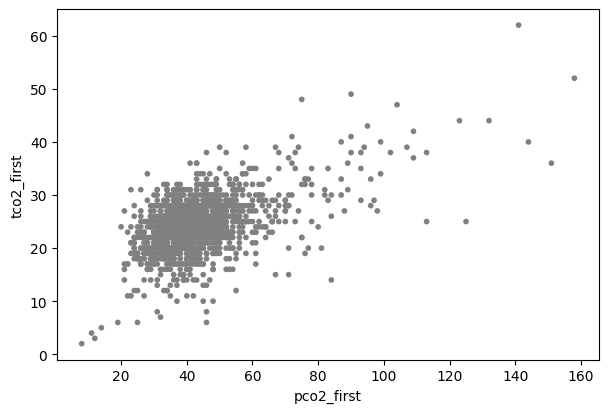

In [151]:
ax = ep.pl.scatter(adata, x="pco2_first", y="tco2_first")

Finding the best fit line for the scatter plot above using `ep.tl.ols (ehrapy.tools.ols)` is relatively straightforward:

In [152]:
var_names = ["pco2_first", "tco2_first", "gender_num"]
formula = "tco2_first ~ pco2_first"
co2_lm = ep.tl.ols(adata, var_names, formula, missing="drop")

Dissecting this command from left to right: The `co2_lm =` part assigns the right part of the command to a new variable called `co2_lm`.  The right side of this command runs the `OLS` function in `Python`. The basic `OLS` command has two parts.  The first is the formula which has the general syntax `outcome ~ covariates`.  Here, our outcome variable is called `tco2_first` and we are just fitting one covariate, `pco2_first`, so our formula is `tco2_first ~ pco2_first`.  The second argument is separated by a comma and is specifying the data frame to use.  In our case, the data frame is called `dat`, so we pass `data=dat`, noting that both `tco2_first` and `pco2_first` are columns in the dataframe `dat`. The overall procedure of specifying a model formula (`tco2_first ~ pco2_first`), a data frame (`data=dat`) and passing it an appropriate `Python` function (`OLS`) will be used throughout this chapter, and is the foundation for many types of statistical modeling in `Python`.

We would like to see some information about the model we just fit, and often a good way of doing this is to run the `summary` command on the object we created:

In [153]:
co2_lm_result = co2_lm.fit()
co2_lm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tco2_first   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     571.8
Date:                Wed, 13 Nov 2024   Prob (F-statistic):          3.52e-108
Time:                        14:45:49   Log-Likelihood:                -4609.1
No. Observations:                1590   AIC:                             9222.
Df Residuals:                    1588   BIC:                             9233.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2109      0.360     45.071      0.000      15.505      16.916
pco2_first     0.1886      0.008     23.912      0.000       0.173       0.204
==============================================================================
Omnibus:                       94.233   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.722
Skew:                          -0.389   Prob(JB):                     3.16e-43
Kurtosis:                       4.532   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This outputs information about the `OLS` object we created in the previous step.  The first part recalls the model we fit, which is useful when we have fit many models, and are trying to compare them.  The second part lists some summary information about what are called residuals -- a topic we will cover later on in this book (Chapter 2.6).  Next lists the coefficient estimates -- these are the $\hat{\beta}_0$, `(Intercept)`, and $\hat{\beta}_1$, `pco2_first`, parameters in the best fit line we are trying to estimate.  This output is telling us that the best fit equation for the data is:

`tco2_first` = 16.21 + 0.189 $\times$ `pco2_first`.

### Model Selection

Model selection is the procedure to select the best model from a list (perhaps rather large list) of candidate models. Different approaches and techniques exist for this procedure.  We will cover some basics here, as more complicated techniques will be covered in a later chapter.  In the simplest case, we have two models, and we want to know which one we should use.

We will begin by examining if the relationship between TCO2 and PCO2 is more complicated than the model we fit in the previous section.  If you recall, we fit a model where we considered a linear `pco2_first` term: `tco2_first` = $\beta_0 + \beta_1 \times$ `pco2_first`.  One may wonder if including a quadratic term would fit the data better, i.e. whether:

`tco2_first` = $\beta_0 + \beta_1 \times$ `pco2_first` + $\beta_2 \times$ `pco2_first`$^2$,

is a better model.

Adding a quadratic term (or any other function) is quite easy using the `OLS` function. Fitting this model, and running the `summary` function for the model:

In [154]:
formula = "tco2_first ~ pco2_first + np.square(pco2_first)"

o2_quad_lm = ep.tl.ols(adata, var_names, formula, missing="drop")
co2_quad_lm_result = o2_quad_lm.fit()
co2_quad_lm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tco2_first   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     285.7
Date:                Wed, 13 Nov 2024   Prob (F-statistic):          1.04e-106
Time:                        14:45:49   Log-Likelihood:                -4609.1
No. Observations:                1590   AIC:                             9224.
Df Residuals:                    1587   BIC:                             9240.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.0916      0.771     20.862      0.000      14.579      17.605
pco2_first                0.1930      0.027      7.231      0.000       0.141       0.245
np.square(pco2_first) -3.569e-05      0.000     -0.175      0.861      -0.000       0.000
==============================================================================
Omnibus:                       93.522   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.937
Skew:                          -0.385   Prob(JB):                     4.68e-43
Kurtosis:                       4.533   Cond. No.                     1.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking first at the coefficients estimates, we see the best fit line is estimated as:

`tco2_first` = 16.09 + 0.19 $\times$ `pco2_first` + 0.00004 $\times$ `pco2_first`$^2$.


We can add both best fit lines to the former scattered points.

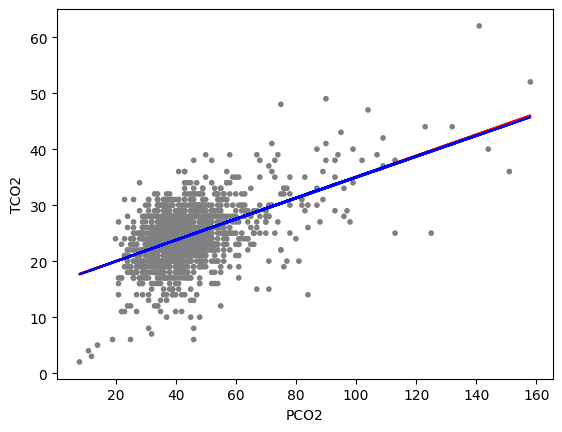

In [155]:
ep.pl.ols(
    adata,
    x="pco2_first",
    y="tco2_first",
    ols_results=[co2_lm_result, co2_quad_lm_result],
    ols_color=["red", "blue"],
    xlabel="PCO2",
    ylabel="TCO2",
    show=True,
)

Figure Scatterplot of PCO2 (x-axis) and TCO2 (y-axis) along with linear regression estimates from the quadratic model (co2_quad_lm) and linear only model (co2_lm)

And one can see that the red (linear term only) and blue (linear and quadratic terms) fits are nearly identical.  This corresponds with the relatively small coefficient estimate for the `(pco2_first^2)` term.  The p-value for this coefficient is about 0.86, and at the 0.05 significance level we would likely conclude that a quadratic term is not necessary in our model to fit the data, as the linear term only model fits the data nearly as well.

#### Statistical Interactions and Testing Nested Models

We can also consider additional features in our model. For this, we can start with e.g. gender as a covariate, but no interaction.  We can do this by simply adding the variable `gender_num` to the previous formula for our `co2_lm` model fit.

In [156]:
formula = "tco2_first ~ pco2_first + gender_num"
var_names = ["tco2_first", "pco2_first", "gender_num"]
co2_gender_lm = ep.tl.ols(adata, var_names, formula, missing="drop")
co2_gender_lm_result = co2_gender_lm.fit()
co2_gender_lm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tco2_first   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     286.1
Date:                Wed, 13 Nov 2024   Prob (F-statistic):          7.60e-107
Time:                        14:45:49   Log-Likelihood:                -4608.7
No. Observations:                1590   AIC:                             9223.
Df Residuals:                    1587   BIC:                             9240.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.3044      0.378     43.166      0.000      15.564      17.045
pco2_first     0.1889      0.008     23.922      0.000       0.173       0.204
gender_num    -0.1817      0.224     -0.812      0.417      -0.621       0.257
==============================================================================
Omnibus:                       94.658   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.982
Skew:                          -0.394   Prob(JB):                     4.57e-43
Kurtosis:                       4.524   Cond. No.                         160.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This output is very similar to what we had before, but now there's a `gender_num` term as well.  The `1` is present in the first column after `gender_num`, and it tells us who this coefficient is relevant to (subjects with `1` for the `gender_num` -- men).  This is always relative to the baseline group, and in this case this is women.  The estimate is negative, meaning that the line fit for males will be below the line for females.  Plotting this fit curve:

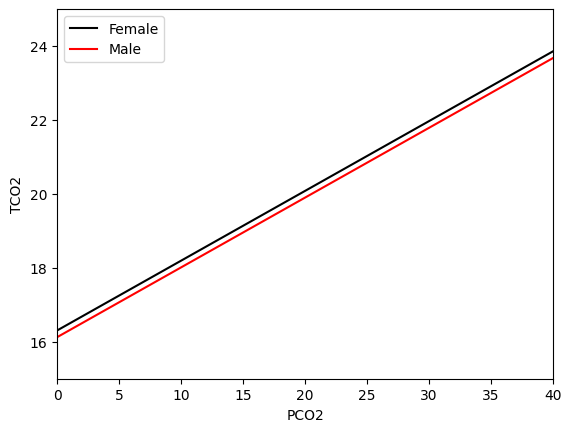

In [157]:
# s stands for slope of the line, i stands for intercept of the line
s_female = co2_gender_lm_result.params[1]
i_female = co2_gender_lm_result.params[0]
s_male = co2_gender_lm_result.params[1]
i_male = co2_gender_lm_result.params[0] + co2_gender_lm_result.params[2]
ep.pl.ols(
    lines=[(s_female, i_female), (s_male, i_male)],
    lines_color=["k", "r"],
    lines_label=["Female", "Male"],
    xlabel="PCO2",
    ylabel="TCO2",
    xlim=(0, 40),
    ylim=(15, 25),
    show=True,
)

We see that the lines are parallel, but almost indistinguishable.  In fact, this plot has been cropped in order to see any difference at all.  From the estimate from the `summary` output above, the difference between the two lines is -0.182 mmol/L, which is quite small, so perhaps this isn't too surprising.  We can also see in the above `summary` output that the p-value is about 0.42, and we would likely *not* reject the null hypothesis that the true value of the `gender_num` coefficient is zero.

Next, we can explore our model with an interaction between `pco2_first` and `gender_num`.  To add an interaction between two variables use the `*` operator within a model formula.  By default, `Python` will add all of the main effects (variables contained in the interaction) to the model as well, so simply adding `pco2_first*gender_num` will add effects for `pco2_first` and `gender_num` in addition to the interaction between them to the model fit.


In [158]:
formula = "tco2_first ~ pco2_first * gender_num"
var_names = ["tco2_first", "pco2_first", "gender_num"]

co2_gender_interaction_lm = ep.tl.ols(adata, var_names, formula, missing="drop")
co2_gender_interaction_lm_result = co2_gender_interaction_lm.fit()
co2_gender_interaction_lm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tco2_first   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     191.6
Date:                Wed, 13 Nov 2024   Prob (F-statistic):          5.09e-106
Time:                        14:45:49   Log-Likelihood:                -4607.7
No. Observations:                1590   AIC:                             9223.
Df Residuals:                    1586   BIC:                             9245.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.8544      0.489     32.443      0.000      14.896      16.813
pco2_first                0.1994      0.011     18.585      0.000       0.178       0.220
gender_num                0.8144      0.722      1.128      0.260      -0.602       2.231
pco2_first:gender_num    -0.0230      0.016     -1.450      0.147      -0.054       0.008
==============================================================================
Omnibus:                       97.108   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.324
Skew:                          -0.403   Prob(JB):                     3.16e-44
Kurtosis:                       4.541   Cond. No.                         399.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimated coefficients are $\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2$ and $\hat{\beta}_3$, respectively, and we can determine the best fit lines for men:


`tco2_first` = $(15.85 + 0.81)$ + $(0.20 - 0.023)$ $\times$ `pco2_first` =  $16.67$ + $0.18$ $\times$ `pco2_first`,

and for women:

`tco2_first` = $15.85$ + $0.20$ $\times$ `pco2_first`.

Based on this, the men's intercept should be higher, but their slope should be not as steep, relative to the women.  Let's check this and add the new model fits as dotted lines and add a legend to the above figure.


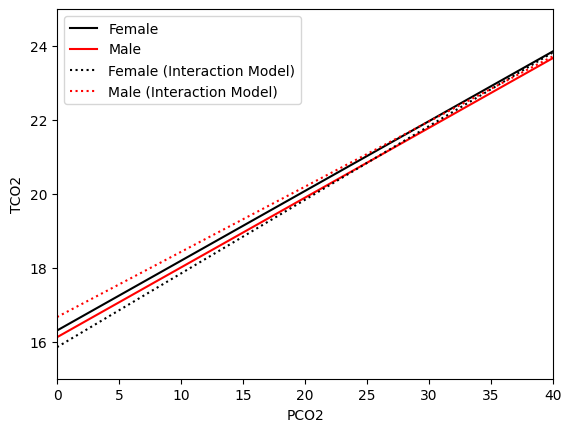

In [159]:
# s stands for slope of the line, i stands for intercept of the line
s_female_interaction = co2_gender_interaction_lm_result.params[1]
i_female_interaction = co2_gender_interaction_lm_result.params[0]
s_male_interaction = (
    co2_gender_interaction_lm_result.params[1]
    + co2_gender_interaction_lm_result.params[3]
)
i_male_interaction = (
    co2_gender_interaction_lm_result.params[0]
    + co2_gender_interaction_lm_result.params[2]
)

lines = [
    (s_female, i_female),
    (s_male, i_male),
    (s_female_interaction, i_female_interaction),
    (s_male_interaction, i_male_interaction),
]
lines_color = ["k", "r", "k", "r"]
lines_style = ["-", "-", ":", ":"]
lines_label = [
    "Female",
    "Male",
    "Female (Interaction Model)",
    "Male (Interaction Model)",
]
ep.pl.ols(
    lines=lines,
    lines_color=lines_color,
    lines_style=lines_style,
    lines_label=lines_label,
    xlabel="PCO2",
    ylabel="TCO2",
    xlim=(0, 40),
    ylim=(15, 25),
    show=True,
)

Regression fits of PCO2 on TCO2 with gender (black female; red male; solid no interaction; dotted with interaction). Note both axes are cropped for illustration purposes

We can see that the fits generated from this plot are a little different than the one generated for a model without the interaction.  The biggest difference is that the dotted lines are no longer parallel.  This has some serious implications, particularly when it comes to interpreting our result.  First note that the estimated coefficient for the `gender_num` variable is now positive.  This means that at `pco2_first=0`, men (red) have higher `tco2_first` levels than women (black).  If you recall in the previous model fit, women had higher levels of `tco2_first` at all levels of `pco2_first`.  At some point around `pco2_first=35` this changes and women (black) have higher `tco2_first` levels than men (red).  This means that the effect of `gender_num` *may* vary as you change the level of `pco2_first`, and is why interactions are often referred to as effect modification in the epidemiological literature.  The effect need not change signs (i.e., the lines do not need to cross) over the observed range of values for an interaction to be present.

The question remains, is the variable `gender_num` important?  We looked at this briefly when we examined the `t value` column in the no interaction model which included `gender_num`.  What if we wanted to test (simultaneously) the null hypothesis: $\beta_2$  *and*  $\beta_3=0$  There is a useful test known as the F-test which can help us in this exact scenario where we want to look at if we should use a larger model (more covariates) or use a smaller model (fewer covariates).  The F-test applies only to *nested models* -- the larger model *must* contain each covariate that is used in the smaller model, and the smaller model *cannot* contain covariates which are not in the larger model.  The interaction model and the model with gender are nested models since all the covariates in the model with gender are also in the larger interaction model.  An example of a non-nested model would be the quadratic model and the interaction model: the smaller (quadratic) model has a term (`pco2_first`$^2$) which is not in the larger (interaction) model.  An F-test would not be appropriate for this latter case.

To perform an F-test, first fit the two models you wish to consider, and then run the `anova_lm` command passing the two model objects.



In [160]:
anova_lm(co2_lm_result, co2_gender_interaction_lm_result)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1588.0,30674.431382,0.0,NaN,NaN,NaN
1,1586.0,30621.082804,2.0,53.348578,1.381578,0.251484


As you can see, the `anova_lm` command first lists the models it is considering.  Much of the rest of the information is beyond the scope of this chapter, but we will highlight the reported F-test p-value (`Pr(>F)`), which in this case is 0.2515.  In nested models, the null hypothesis is that all coefficients in the larger model and not in the smaller model are zero.  In the case we are testing, our null hypothesis is $\beta_2$  *and*  $\beta_3=0$.  Since the p-value exceeds the typically used significance level ($\alpha=0.05$), we would not reject the null hypothesis, and likely say the smaller model explains the data just as well as the larger model.  If these were the only models we were considering, we would use the smaller model as our final model and report the final model in our results.  We will now discuss what exactly you should report and how you can interpret the results.

### Reporting and Interpreting Linear Regression

Confidence and Prediction Intervals

As mentioned above, one method to quantify the uncertainty around coefficient estimates is by reporting the standard error.  Another commonly used method is to report a confidence interval, most commonly a 95\% confidence interval.  A 95\% confidence interval for $\beta$ is an interval for which if the data were collected repeatedly, about 95\% of the *intervals* would contain the *true value* of the parameter, $\beta$, assuming the modeling assumptions are correct.

To get 95\% confidence intervals of coefficients, `Python` has a `confint` function, which you pass an `lm` object to.  It will then output 2.5\% and 97.5\% confidence interval limits for each coefficient.


In [161]:
co2_lm_result.conf_int()

,0,1
Intercept,15.505369,16.916349
pco2_first,0.173103,0.204040


The 95\% confidence interval for `pco2_first` is about 0.17-0.20, which may be slightly more informative than reporting the standard error.  Often people will look at if the confidence interval includes zero (no effect). Since it does not, and in fact since the interval is quite narrow and not very close to zero, this provides some additional evidence of its importance.  There is a well known link between hypothesis testing and confidence intervals which we will not get into detail here.

When plotting the data with the model fit, similar to Figure 16.2, it is a good idea to include some sort of assessment of uncertainty as well.  To do this in `Python`, we will first create a data frame with PCO2 levels which we would like to predict.  In this case, we would like to predict the outcome (TCO2) over the range of observed covariate (PCO2) values.  We do this by creating a data frame, where the variable names in the data frame must match the covariates used in the model.  In our case, we have only one covariate (`pco2_first`), and we predict the outcome over the range of covariate values we observed determined by the `min` and `max` functions.

In [162]:
pco2_first = pd.DataFrame(adata[:, "pco2_first"].X).dropna().astype(int)
data = {"pco2_first": [i for i in range(pco2_first.min()[0], pco2_first.max()[0])]}
grid_pred = pd.DataFrame(data)

In [163]:
preds = co2_lm_result.get_prediction(grid_pred).summary_frame()[
    ["mean", "obs_ci_lower", "obs_ci_upper"]
]
preds[0:2]

,mean,obs_ci_lower,obs_ci_upper
0,17.719434,9.078647,26.360220
1,17.908005,9.268186,26.547825


We have printed out the first two rows of our predictions, preds, which are the model’s predictions for PCO2 at 8 and 9. We can see that our predictions (mean) are about 0.18 apart, which make sense given our estimate of the slope (0.18). We also see that our 95 % prediction intervals are very wide, spanning about 9 (obs_ci_lower) to 26 (obs_ci_upper). This indicates that, despite coming up with a model which is very statisti- cally significant, we still have a lot of uncertainty about the predictions generated from such a model. It is a good idea to capture this quality when plotting how well your model fits by adding the interval lines as dotted lines. Let’s plot our final model fit, co2.lm, along with the scatterplot and prediction interval in the figure below.

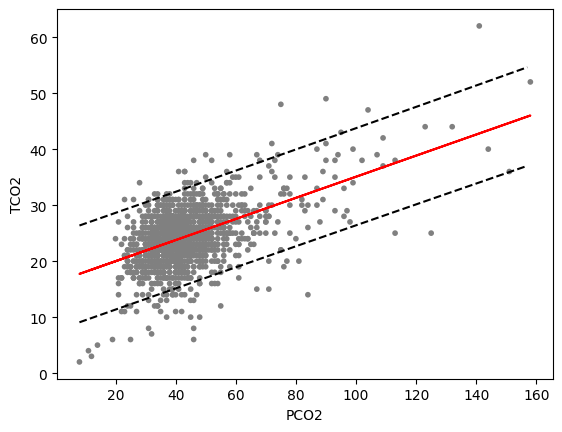

In [164]:
ep.pl.ols(
    adata,
    x="pco2_first",
    y="tco2_first",
    ols_results=[co2_lm_result],
    ols_color=["red"],
    lines=[
        (grid_pred["pco2_first"], preds["obs_ci_upper"]),
        (grid_pred["pco2_first"], preds["obs_ci_lower"]),
    ],
    lines_color=["k", "k"],
    lines_style=["--", "--"],
    xlabel="PCO2",
    ylabel="TCO2",
    show=True,
)

Scatterplot of PCO2 (x-axis) and TCO2 (y-axis) along with linear regression estimates from the linear only model (co2_lm). The dotted line represents 95 % prediction intervals for the model

## Logistic Regression
So far, we have considered how a _continuous_ variable can be modeled using our features. Another very common modelling task is the one of classification. Here, we are interested to model a _discrete_ label using our features. A very common scenario is to have a binary class label, for example whether a patient survived a 28-day observation window or not.

### 2 * 2 Tables

In [165]:
var_names = ["age", "day_28_flg", "service_unit"]
dat = pd.DataFrame(adata[:, var_names].X, columns=var_names)
dat["age"] = dat["age"].astype("float").dropna(axis=0)

Contingency tables are the best way to start to think about binary data.  A contingency table cross-tabulates the outcome across two or more levels of a covariate.  Let's begin by creating a new variable (`age.cat`) which dichotomizes `age` into two age categories: $\le55$ and $>55$.  Note, because we are making age a discrete variable, we also change the data type to a factor.  This is similar to what we did for the `gender_num` variable when discussing linear regression in the previous subchapter.

In [166]:
dat["age_cat"] = np.where(dat["age"] <= 55, "<=55", ">55")
dat["age_cat"] = dat["age_cat"].astype("category")
dat["age_cat"].value_counts()

age_cat
<=55    923
>55     853
Name: count, dtype: int64

We would like to see how 28 day mortality is distributed among the age categories.  We can do so by constructing a contingency table, or in this case what is commonly referred to as a 2x2 table.

In [167]:
age_cat_day_28_flg = pd.crosstab(index=dat["age_cat"], columns=dat["day_28_flg"])
age_cat_day_28_flg.columns = ["0", "1"]
age_cat_day_28_flg.index = ["<=55", ">55"]
age_cat_day_28_flg

,0,1
<=55,883,40
>55,610,243


Now let us look at a slightly different case -- when the covariate takes on more than two values.  Such a variable is the `service_unit`.  Let's see how the deaths are distributed among the different units:

In [168]:
deathbyservice = pd.crosstab(index=dat["service_unit"], columns=dat["day_28_flg"])
deathbyservice.columns = ["0", "1"]
deathbyservice.index = ["FICU", "MICU", "SICU"]
deathbyservice

,0,1
FICU,59,3
MICU,605,127
SICU,829,153


we can get frequencies of these service units by applying the `prop.table` function to our cross-tabulated table.

In [169]:
deathbyservice.div(deathbyservice["0"] + deathbyservice["1"], axis=0)

,0,1
FICU,0.951613,0.048387
MICU,0.826503,0.173497
SICU,0.844196,0.155804


It appears as though the `FICU` may have a lower rate of death than either the `MICU` or `SICU`.  To compute an odds ratios, first compute the odds:


In [170]:
deathbyservice["1"].div(deathbyservice["0"], axis=0)

FICU    0.050847
MICU    0.209917
SICU    0.184560
dtype: float64

And then we need to pick which of `FICU`, `MICU` or `SICU` will serve as the reference or baseline group.  This is the group which the other two groups will be compared to.  Again the choice is arbitrary, but should be dictated by the study objective.  If this were a clinical trial with two drug arms and a placebo arm, it would be foolish to use one of the treatments as the reference group, particularly if you wanted to compare the efficacy of the treatments.  In this particular case, there is no clear reference group, but since the FICU is so much smaller than the other two units, we will use it as the reference group.  Computing the odds ratio for MICU and SICU we get 4.13 and 3.63, respectively.  These are also very strong associations, meaning that the odds of dying in the SICU and MICU are around 4 times higher than in the FICU, but relatively similar.

Contingency tables and 2x2 tables in particular are the building blocks of working with binary data, and it's often a good way to begin looking at the data.

### Introducing Logistic Regression

Let's fit this model, and see how this works using a real example.  We fit logistic regression very similarly to how we fit linear regression models, with a few exceptions.  First, we will use a new function called `glm`, which allows one to fit a class of models known as generalized linear models or GLMs.  The `glm` function works in much the same way the `lm` function does.  We need to specify a formula of the form: `outcome ~ covariates`, specify what dataset to use (in our case the `dat` data frame), and then specify the family.  For logistic regression `family='binomial'` will be our choice.  You can run the `summary` function, just like you did for `lm` and it produces output very similar to what `lm` did.


In [171]:
dat["day_28_flg"] = np.where(dat["day_28_flg"] == 0, 1, 0)

In [172]:
adata_new = ep.ad.df_to_anndata(dat)

In [173]:
formula = "day_28_flg ~ age_cat"
var_names = ["day_28_flg", "age_cat"]

age_glm = ep.tl.glm(adata_new, var_names, formula, family="Binomial", missing="drop")
age_glm_result = age_glm.fit()
print(age_glm_result.summary())

                         Generalized Linear Model Regression Results                          
Dep. Variable:     ['day_28_flg[0]', 'day_28_flg[1]']   No. Observations:                 1776
Model:                                            GLM   Df Residuals:                     1774
Model Family:                                Binomial   Df Model:                            1
Link Function:                                  Logit   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -674.34
Date:                                Wed, 13 Nov 2024   Deviance:                       1348.7
Time:                                        14:45:50   Pearson chi2:                 1.78e+03
No. Iterations:                                     6   Pseudo R-squ. (CS):             0.1111
Covariance Type:                            nonrobust                                         
                     coef    std err          z   

As you can see, we get a coefficients table that is similar to the `lm` table we used earlier.  Instead of a `t value`, we get a `z value`, but this can be interpreted similarly.  The rightmost column is a p-value, for testing the null hypothesis $\beta=0$.  If you recall, the non-intercept coefficients are log-odds ratios, so testing if they are zero is equivalent to testing if the odds ratios are one.  If an odds ratio is one the odds are equal in the numerator group and denominator group, indicating the probabilities of the outcome are equal in each group.  So, assessing if the coefficients are zero will be an important aspect of doing this type of analysis.

#### Beyond a Single Binary Covariate

While the above analysis is useful for illustration, it does not readily demonstrate anything we could not do with our 2x2 table example above.  Logistic regression allows us to extend the basic idea to at least two very relevant areas.  The first is the case where we have more than one covariate of interest.  Perhaps we have a confounder we are concerned about, and want to adjust for it.  Alternatively, maybe there are two covariates of interest.  Secondly, it allows use to use covariates as continuous quantities, instead of discretizing them into categories.  For example, instead of dividing age up into exhaustive strata (as we did very simply by just dividing the patients into two groups, $\le55$ and $>55$ ), we could instead use age as a continuous covariate.

First, having more than one covariate is simple.  For example, if we wanted to add `service_unit` to our previous model, we could just add it as we did when using the `lm` function for linear regression.  Here we specify `day_28_flg ~ age.cat + service_unit` and run the `summary` function.

In [174]:
formula = "day_28_flg ~ age_cat + service_unit"
var_names = ["day_28_flg", "age_cat", "service_unit"]

ageunit_glm = ep.tl.glm(
    adata_new, var_names, formula, family="Binomial", missing="drop"
)
ageunit_glm_result = ageunit_glm.fit()
print(ageunit_glm_result.summary())

                         Generalized Linear Model Regression Results                          
Dep. Variable:     ['day_28_flg[0]', 'day_28_flg[1]']   No. Observations:                 1776
Model:                                            GLM   Df Residuals:                     1772
Model Family:                                Binomial   Df Model:                            3
Link Function:                                  Logit   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -671.87
Date:                                Wed, 13 Nov 2024   Deviance:                       1343.7
Time:                                        14:45:50   Pearson chi2:                 1.74e+03
No. Iterations:                                     6   Pseudo R-squ. (CS):             0.1136
Covariance Type:                            nonrobust                                         
                           coef    std err        

A coefficient table is produced, and now we have four estimated coefficients.  The same two, `(Intercept)` and `age_cat[T.>55]` which were estimated in the unadjusted model, but also we have `service_unit[T.MICU]` and `service_unit[T.SICU]` which correspond to the log odds ratios for the MICU and SICU relative to the FICU.  Taking the exponential of these will result in an odds ratio for each variable, adjusted for the other variables in the model.  In this case the adjusted odds ratios for Age>55, MICU and SICU are 8.68, 3.25, and 3.08, respectively. We would conclude that there is an almost 9-fold increase in the odds of 28 day mortality for those in the $>55$ year age group relative to the younger $\le55$ group while holding service unit constant.  This adjustment becomes important in many scenarios where groups of patients may be more or less likely to receive treatment, but also more or less likely to have better outcomes, where one effect is confounded by possibly many others.  Such is almost always the case with observational data, and this is why logistic regression is such a powerful data analysis tool in this setting.

Another case we would like to be able to deal with is when we have a continuous covariate we would like to include in the model.  One can always break the continuous covariate into mutually exclusive categories by selecting break or cut points, but selecting the number and location of these points can be arbitrary, and in many cases unnecessary or inefficient.  Recall that in logistic regression we are fitting a model:


$logit(p_x) = log(Odds_x) = log(\frac{p_x}{1-p_x}) = \beta_0 + \beta_1 \times x$,


but now assume $x$ is continuous.  Imagine a hypothetical scenario where you know $\beta_0$ and $\beta_1$ and have a group of 50 year olds, and a group of 51 year olds.  The difference in the log Odds between the two groups is:


$log(Odds_{51}) -log(Odds_{50}) = (\beta_0 + \beta_1 \times 51) - (\beta_0 + \beta_1 \times 50) = \beta_1(51-50) = \beta_1$.

Hence, the odds ratio for 51 year olds versus 50 year olds is $\exp{(\beta_1)}$.  This is actually true for any group of patients which are 1 year apart, and this gives a useful way to interpret and use these estimated coefficients for continuous covariates.  Let's work with an example.  Again fitting the 28 day mortality outcome as a function of age, but treating age as it was originally recorded in the dataset, a continuous variable called `age`.

In [175]:
formula = "day_28_flg ~ age"
var_names = ["day_28_flg", "age"]
agects_glm = ep.tl.glm(
    adata_new,
    var_names,
    formula,
    family="Binomial",
    missing="drop",
    as_continuous=["age"],
)
agects_glm_result = agects_glm.fit()
print(agects_glm_result.summary())

                         Generalized Linear Model Regression Results                          
Dep. Variable:     ['day_28_flg[0]', 'day_28_flg[1]']   No. Observations:                 1776
Model:                                            GLM   Df Residuals:                     1774
Model Family:                                Binomial   Df Model:                            1
Link Function:                                  Logit   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -625.49
Date:                                Wed, 13 Nov 2024   Deviance:                       1251.0
Time:                                        14:45:50   Pearson chi2:                 1.81e+03
No. Iterations:                                     6   Pseudo R-squ. (CS):             0.1587
Covariance Type:                            nonrobust                                         
                 coef    std err          z      P

We see the estimated coefficient is 0.07 and still very statistically significant.  Exponentiating the log odds ratio for age, we get an estimated odds ratio of 1.07, which is per 1 year increase in age.  What if the age difference of interest is ten years instead of one year?  There are at least two ways of doing this.  One is to replace `age` with `I(age/10)`, which uses a new covariate which is `age` divided by ten.  The second is to use the `agects.glm` estimated log odds ratio, and multiple by ten prior to exponentiating.  They will yield equivalent estimates of 1.92, but it is now per 10 year increases in age.  This is useful when the estimated odds ratios (or log odds ratios) are close to one (or zero).  When this is done, one unit of the covariate is 10 years, so the generic interpretation of the coefficients remains the same, but the units (per 10 years instead of per 1 year) changes.

This of course assumes that the form of our equation relating the log odds of the outcome to the covariate is correct.  In cases where odds of the outcome decreases and increases as a function of the covariate, it is possible to estimate a relatively small effect of the linear covariate, when the outcome may be strongly affected by the covariate, but not in the way the model is specified.  Assessing the linearity of the log odds of the outcome and some discretized form of the covariate can be done graphically.  For instance, we can break age into 5 groups, and estimate the log odds of 28 day mortality in each group.

### Hypothesis Testing and Model Selection

As was the case when using `lm`, we first fit the two competing models, a larger (alternative model), and a smaller (null model).  Provided that the models are nested, our larger model is the one which contained `service_unit` and `age.cat`, and the smaller only contains `age.cat`, so they are nested.  We are then testing if the log odds ratios for the two coefficients associated with `service_unit` are zero.  Let's call these coefficients $\beta_{MICU}$ and $\beta_{SICU}$.  To test if $\beta_{MICU}$ and $\beta_{SICU} = 0$, we can perform the following test:


In [176]:
ep.tl.anova_glm(
    age_glm_result,
    ageunit_glm_result,
    "day_28_flg ~ age",
    "day_28_flg ~ age + service_unit",
)

,Model,formula,Df Resid.,Dev.,Df_diff,Pr(>Chi)
0,1,day_28_flg ~ age,1774,1348.676905,NaN,NaN
1,2,day_28_flg ~ age + service_unit,1772,1343.745416,2.0,0.085237


A couple good practices to get in a habit are to first make sure the two competing models are correctly specified.  Here we are are testing `~ age.cat` versus `age.cat + service_unit`.  Next, the difference between the residual degrees of freedom (`Resid. Df`) in the two models tell us how many more parameters the larger model has when compared to the smaller model.  Here we see `1774 - 1772 = 2` which means that there are two more coefficients estimated in the larger model than the smaller one, which corresponds with the output from the `summary` table above.  Next looking at the p-value (`Pr(>Chi)`), we see a test for $\beta_{MICU}$ and $\beta_{SICU} = 0$ has a p-value of around 0.08.  At the typical 0.05 significance level, we would not reject the null, and use the simpler model without the service unit.  In logistic regression, this is a common way of testing whether a categorical covariate should be retained in the model, as it can be difficult to assess using the `z value` in the `summary` table, particularly when one is very statistically significant, and one is not.

### Confidence Intervals

Generating confidence intervals for either the log-odds ratios or the odds ratios are relatively straightforward.  To get the log-odds ratios and respective confidence intervals for the `ageunit_glm` model which includes both age and service unit:

In [177]:
ageunit_glm_result.params

Intercept              -4.209014
age_cat[T.>55]          2.161142
service_unit[T.MICU]    1.178866
service_unit[T.SICU]    1.123443
dtype: float64

In [178]:
ageunit_glm_result.conf_int(alpha=0.05)

,0,1
Intercept,-5.429257,-2.988771
age_cat[T.>55],1.810733,2.511552
service_unit[T.MICU],-0.027452,2.385184
service_unit[T.SICU],-0.079611,2.326497


Here the coefficient estimates and confidence intervals are presented in much the same way as for a linear regression. In logistic regression, it is often convenient to exponentiate these quantities to get it on a more interpretable scale.

In [179]:
np.exp(ageunit_glm_result.params)

Intercept               0.014861
age_cat[T.>55]          8.681049
service_unit[T.MICU]    3.250686
service_unit[T.SICU]    3.075425
dtype: float64

In [180]:
np.exp(ageunit_glm_result.conf_int(alpha=0.025))

,0,1
Intercept,0.003681,0.059992
age_cat[T.>55],5.814857,12.960011
service_unit[T.MICU],0.818181,12.915179
service_unit[T.SICU],0.776964,12.173333


Similar to linear regression, we will check whether the confidence intervals for the log odds ratios include zero.  This is equivalent to seeing if the intervals for the odds ratios include 1.  Since the odds ratios are more directly interpretable it is often more convenient to report them instead of the coefficients on the log odds ratio scale.

### Prediction

Let's first create a new data frame called `newdat` which computes all combinations of the values of variables passed to it.

In [181]:
def expand_grid(dictionary):
    return pd.DataFrame(
        [row for row in product(*dictionary.values())], columns=dictionary.keys()
    )


dictionary = {"age_cat": ["<=55", ">55"], "service_unit": ["FICU", "MICU", "SICU"]}

newdat = expand_grid(dictionary)
newdat

,age_cat,service_unit
0,<=55,FICU
1,<=55,MICU
2,<=55,SICU
3,>55,FICU
4,>55,MICU
5,>55,SICU


In [182]:
newdat["pred"] = ageunit_glm_result.predict(newdat)
newdat

,age_cat,service_unit,pred
0,<=55,FICU,0.014643
1,<=55,MICU,0.046082
2,<=55,SICU,0.043706
3,>55,FICU,0.114268
4,>55,MICU,0.295461
5,>55,SICU,0.284056


## Survival Analysis

### correct the observation

In [183]:
adata_subset = adata[
    :, ["mort_day_censored", "censor_flg", "gender_num", "service_unit"]
]

Normally, you can skip the next step, but since this dataset was used to analyze
the data in a slightly different way, we need to correct the observation times for a
subset of the subjects in the dataset.

In [184]:
adata_subset[:, ["mort_day_censored"]].X[adata_subset[:, ["censor_flg"]].X == 1] = 731

### Kaplan-Meier Survival Curves

Kaplan-Meier plots are one of the most widely used plots in medical research. We can use `ehrapy.tools.kmp` (`ep.tl.kmp`), which internally calls KaplanMeierFitter, to fit the Kaplan-Meier estimate for the survival function. The function normally takes two arguments: a vector of times, and some kind of indicator for which patients had an event (death in our case). In our case, the vector of death and censoring times are the mort_day_censored, and deaths are coded with a zero in the censor_flg variable.

Note that in the MIMIC-II database, `censor_fl` is censored or death (binary: 0 = death, 1 = censored). <br /> In KaplanMeierFitter, `event_observed` is True if the the death was observed, False if the event was lost (right-censored). <br /> So we need to flip `censor_fl` when pass `censor_fl` to KaplanMeierFitter:

In [185]:
adata_subset[:, ["censor_flg"]].X = np.where(
    adata_subset[:, ["censor_flg"]].X == 0, 1, 0
)

Fitting a Kaplan-Meier curve is quite easy, and we want to ‘fit’ by gender (gender_num). The default alpha value of KaplanMeierFitter is 0.05, which is 95 % confidence intervals for the survival functions. Lastly we add a legend, coding black for the women and red for the men.

In [186]:
T = adata_subset[:, ["mort_day_censored"]].X
E = adata_subset[:, ["censor_flg"]].X
groups = adata_subset[:, ["gender_num"]].X
adata_group_1 = adata_subset[groups == 0]
adata_group_2 = adata_subset[groups == 1]
kmf_1 = ep.tl.kmf(adata_group_1, "mort_day_censored", "censor_flg", label="Women")
kmf_2 = ep.tl.kmf(adata_group_2, "mort_day_censored", "censor_flg", label="Men")

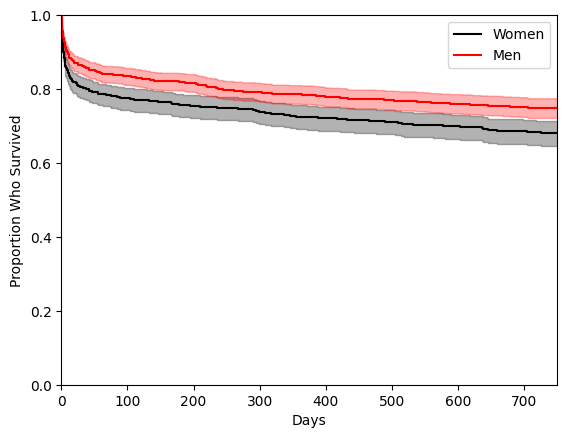

In [187]:
ep.pl.kmf(
    [kmf_1, kmf_2],
    color=["k", "r"],
    xlim=[0, 750],
    ylim=[0, 1],
    xlabel="Days",
    ylabel="Proportion Who Survived",
    show=True,
)

As the above figure shows, there appears to be a difference between the survival function between the two gender groups, with again the male group (red) dying at slightly slower rate than the female group (black). We have included 95 % point-wise confidence bands for the survival function estimate, which assesses how much certain we are about the estimated survivorship at each point in time.

We can do the same for `service_unit`, but since it has three groups, we need to change the color argument and legend to ensure the plot is properly labelled. 

In [188]:
groups = adata_subset[:, ["service_unit"]].X
adata_group_ficu = adata_subset[groups == "FICU"]
adata_group_micu = adata_subset[groups == "MICU"]
adata_group_sicu = adata_subset[groups == "SICU"]
kmf_1 = ep.tl.kmf(adata_group_ficu, "mort_day_censored", "censor_flg", label="FICU")
kmf_2 = ep.tl.kmf(adata_group_micu, "mort_day_censored", "censor_flg", label="MICU")
kmf_3 = ep.tl.kmf(adata_group_sicu, "mort_day_censored", "censor_flg", label="SICU")

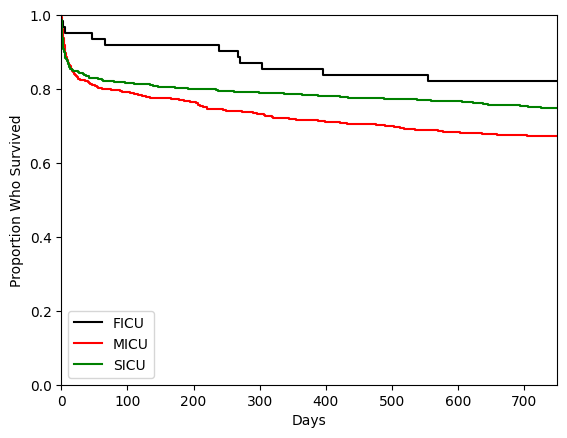

In [189]:
ep.pl.kmf(
    [kmf_1, kmf_2, kmf_3],
    ci_show=[False, False, False],
    color=["k", "r", "g"],
    xlim=[0, 750],
    ylim=[0, 1],
    xlabel="Days",
    ylabel="Proportion Who Survived",
    show=True,
)

### Cox Proportional Hazards Models

The most popular approach for modelling time to event outcomes in health data is likely the Cox Proportional Hazards Model, which is also sometimes called the Cox model or Cox Regression. As the name implies this method models something called the hazard function.

The hazard function is a function of time (hours, days, years) and is approximately the instantaneous probability of the event occurring (i.e., chance the event is happening in some very small time window) given the event has not already happened.

In [190]:
adata_subset = adata_subset[:, ["mort_day_censored", "censor_flg", "gender_num"]]

The CoxPHFitter function (from the lifelines package) is the fitting function for Cox models. In our case, let’s continue our example of using gender (`gender_num`) to model the datSurv outcome we created, and running the summary function to see what information is outputted.

In [191]:
adata_subset[:, ["mort_day_censored"]].X

ArrayView([[11.92],
           [731.0],
           [731.0],
           ...,
           [62.21],
           [234.13],
           [731.0]], dtype=object)

Because `CoxPHFitter.fit()` needs a Pandas DataFrame as input, we have to convert AnnData to DataFrame.

In [192]:
data = ep.ad.anndata_to_df(adata_subset)
data = data.dropna()

In [193]:
gender_coxph = ep.tl.cox_ph(adata_subset, duration_col="mort_day_censored", event_col="censor_flg")

In [194]:
gender_coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 1775 total observations, 1278 right-censored observations>
             duration col = 'mort_day_censored'
                event col = 'censor_flg'
      baseline estimation = breslow
   number of observations = 1775
number of events observed = 497
   partial log-likelihood = -3636.11
         time fit was run = 2024-11-13 13:45:50 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
gender_num -0.29      0.75      0.09           -0.47           -0.11                0.63                0.89

            cmp to     z      p  -log2(p)
covariate                                
gender_num    0.00 -3.24 <0.005      9.71
---
Concordance = 0.54
Partial AIC = 7274.23
log-likelihood ratio test = 10.43 on 1 df
-log2(p) of ll-ratio test = 9.65

The coefficients table has the familiar format, which we’ve seen before. The
coef for `gender_num` is about −0.29, and this is the estimate of our log-hazard
ratio. As discussed, taking the exponential of this gives the hazard ratio (HR),
which the summary output computes in the next column (exp(coef)). Here, the
HR is estimated at 0.75, indicating that men have about a 25 % reduction in the
hazards of death, under the proportional hazards assumption.

The next column in the coefficient table has the standard error for the log hazard
ratio, followed by the z score and p-value (Pr(>|z|)), which is very similar to
what we saw in the case of logistic regression. Here we see the p-value is quite
small, and we would reject the null hypothesis that the hazard functions are the
same between men and women. This is consistent with the exploratory figures we
produced using Kaplan-Meier curves in the previous section.

For CoxPHFitter, the
summary function also conveniently outputs the confidence interval of the HR a
few lines down, and here our estimate of the HR is 0.75 (95 % CI: 0.63–0.89,
p = 0.001). This is how the HR would typically be reported.

Using more than one covariate works the same as our other analysis techniques.
Adding a co-morbidity to the model such as atrial fibrillation (`afib_flg`) can be
done as you would do for logistic regression. Because fit a Cox Proportional Hazards Models using CoxPHFitter requires a Pandas DataFrame as input, we also need to create a DataFrame from AnnData.

In [195]:
adata_subset = adata[:, ["mort_day_censored", "censor_flg", "gender_num", "afib_flg"]]

genderafib_coxph = ep.tl.cox_ph(adata_subset, duration_col="mort_day_censored", event_col="censor_flg")
genderafib_coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 1775 total observations, 1278 right-censored observations>
             duration col = 'mort_day_censored'
                event col = 'censor_flg'
      baseline estimation = breslow
   number of observations = 1775
number of events observed = 497
   partial log-likelihood = -3567.43
         time fit was run = 2024-11-13 13:45:50 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
gender_num -0.26      0.77      0.09           -0.44           -0.08                0.65                0.92
afib_flg    1.34      3.84      0.10            1.14            1.54                3.14                4.68

            cmp to     z      p  -log2(p)
covariate                                
gender_num    0.00 -2.88 <0.005      7.99
afib_flg      0.00 13.18 <0.005    129.37
---
Concordance = 0.61
Partial AIC = 7138.85
log-likelihood ratio test = 147.80 on 2 df
-log2(p) of ll-ratio test = 106.62

Here again male gender is associated with reduced time to death, while atrial fibrillation increases the hazard of death by almost four-fold. Both are statistically significant in the summary output.

Cox regression also allows one to use covariates which change over time. This would allow one to incorporate changes in treatment, disease severity, etc. within the same patient without need for any different methodology. The major challenge to do this is mainly in the construction of the dataset, which is discussed in some of the references at the end of this chapter. Some care is required when the time dependent covariate is only measured periodically, as the method requires that it be known at every event time for the entire cohort of patients, and not just those relevant to the patient in question. This is more practical for changes in treatment which may be recorded with some precision, particularly in a database like MIMIC II, and less so for laboratory results which may be measured at the resolution of hours, days or weeks. Interpolating between lab values or carrying the last observation forward has been shown to introduce several types of problems.

### Caveats and Conclusions

Survival analysis is distinguished from other forms of analyses covered in this Chapter, as it allows the data to be censored. As was the case for the other approaches we considered, there are modeling assumptions. For instance, it is important that the censoring is not informative of the survival time. For example, if censoring occurs when treatment is withdrawn because the patient is too sick to continue therapy, this would be an example of informative censoring. The validity of all methods discussed in this section are then invalid. Care should be taken to make sure you understand the censoring mechanism as to avoid any false inferences drawn.

Assessment of the proportional hazards assumption is an important part of any Cox regression analysis. We refer you to the references at the end of this chapter for strategies and alternatives for when the proportional hazards assumption breaks down. In some circumstances, the proportional hazards assumption is not valid, and alternative approaches can be used. As is always the case, when outcomes are dependent (e.g., one patient may contribute more than one observation), the methods discussed in this section should not be used directly. Generally the standard error estimates will be too small, and p-values will be incorrect. The concerns in logistic regression regarding outliers, co-linearity, missing data, and covariates with sparse outcomes apply here as well, as do the concerns about model misspecification for continuous covariates.